In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plot
from scipy.linalg import norm, svd
from scipy.sparse.linalg import svds

In [2]:
def svst(x, L):
    U, S, V = svd(x, full_matrices=False)
    S[S <= L] = 0
    S[S > L] = S[S > L] - L
    return U.dot(np.diag(S)).dot(V)

In [3]:
def fista_with_nesterov(x_0, mask):
    
    # store the current x for the iteration at step one
    x_prev = x_0
    x = x_0
    
    # at step 0 y_1 = x_0 and t1 =1
    y = x_0
    t = 1
    
    # initialize the max number of iterations after which to stop the nestorov acceleration
    max_num_iterations = 1000
    
    # lipschitz constant of the gradient of the L1 norm
    L = 0.9
    
    # for calculating convergence using soft-impute
    epsilon = 1e-4
    # cannot divide by 0, so making this as small as posible
    Z_old = 1e-10
    
    for _ in range(max_num_iterations):    
        
        # mask y_k same as x_0
        y[mask] = x_0[mask]
        # set the current x_{k} to p_L(y_k)
        x = svst(y, L)
        
        # apply nesterov acceleration on the gradient descent
        t_next = (1 + np.sqrt(1 + 4 * np.power(t, 2))) / 2
        y_next = x + ((t - 1) / t_next) * (x - x_prev)
        
        # assign values for next iteration
        x_prev = x
        t = t_next
        y = y_next
        
        # convergence check
        Z = np.sum((x[mask] - x_0[mask]) ** 2) + L * norm(x, ord='nuc')
        if abs(Z - Z_old) / Z_old < epsilon:
            break
        Z_old = Z
        
    return x

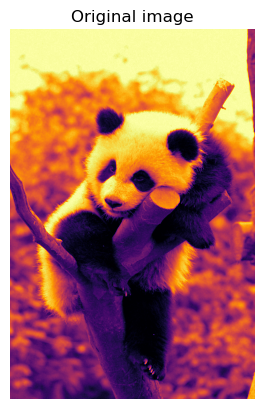

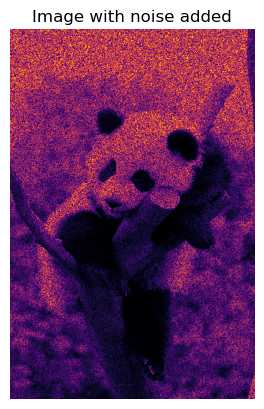

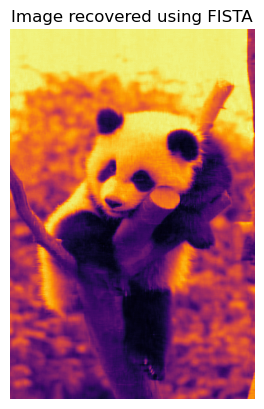

In [4]:
# read in the original image
original_image = cv2.imread('panda.jpg', 0)
# normalize the image
original_image = original_image / 255

# show the original image
plot.imshow(original_image, cmap='inferno')
plot.axis('off')
plot.title(f'Original image')
plot.show()

# select noise percentage to infuse the original with
noise_percentage=0.5
# add random noise to original image
mask = np.random.choice(a=[0,1], size=original_image.shape, p=[noise_percentage, 1-noise_percentage])
noise_image = np.multiply(original_image, mask)

# show image with noise percentage of noise_percentage value
plot.imshow(noise_image, cmap='inferno')
plot.axis('off')
plot.title(f'Image with noise added')
plot.show()

# locate observed entries from the original image
observed_entries = np.where(mask != 0)

# show image processed with FISTA
fista_image = fista_with_nesterov(noise_image, observed_entries)
plot.imshow(fista_image, cmap='inferno')
plot.axis('off')
plot.title(f'Image recovered using FISTA')
plot.show()

In [5]:
def admm(x_0, mask):
    
    # store the current x for the iteration at step one
    x = x_0
    
    # initialize z and u
    z = np.zeros_like(x_0)
    u = np.zeros_like(x_0)
    
    # initialize the max number of iterations after which to stop the nestorov acceleration
    max_num_iterations = 1000
    
    # pick hyperparameters
    rho = 0.02
    L = 0.9
    
    # for calculating convergence using soft-impute
    epsilon = 1e-3
    # cannot divide by 0, so making this as small as posible
    Z_old = 1e-10
    
    for _ in range(max_num_iterations):          
        
        # update values for next iteration
        x = (x_0 + rho * (z - u)) / rho
        x[mask] = x_0[mask]

        z = svst(x + u, L/rho)
        u = u + x - z
        
        # convergence check
        Z = np.sum((x[mask] - x_0[mask]) ** 2) + L/rho * norm(x, ord='nuc')
        if abs(Z - Z_old) / Z_old < epsilon:
            break
        Z_old = Z
        
    return x

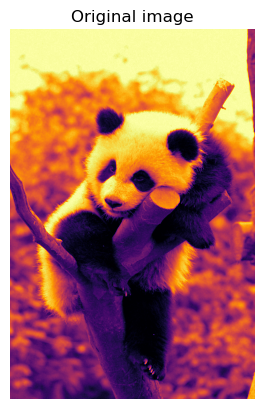

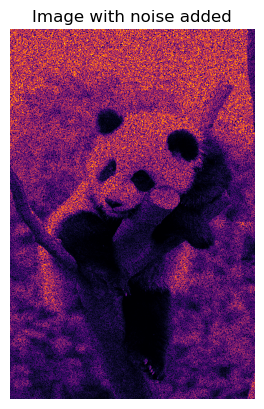

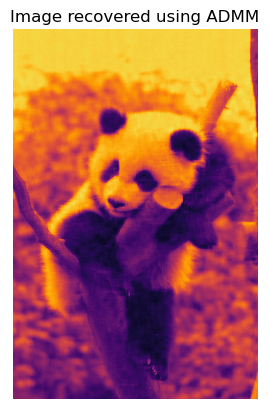

In [6]:
# read in the original image
original_image = cv2.imread('panda.jpg', 0)
# normalize the image
original_image = original_image / 255

# show the original image
plot.imshow(original_image, cmap='inferno')
plot.axis('off')
plot.title(f'Original image')
plot.show()

# select noise percentage to infuse the original with
noise_percentage=0.5
# add random noise to original image
mask = np.random.choice(a=[0,1], size=original_image.shape, p=[noise_percentage, 1-noise_percentage])
noise_image = np.multiply(original_image, mask)

# show image with noise percentage of noise_percentage value
plot.imshow(noise_image, cmap='inferno')
plot.axis('off')
plot.title(f'Image with noise added')
plot.show()

# locate observed entries from the original image
observed_entries = np.where(mask != 0)

# show image processed with ADMM
admm_image = admm(noise_image, observed_entries)
plot.imshow(admm_image, cmap='inferno')
plot.axis('off')
plot.title(f'Image recovered using ADMM')
plot.show()

In [7]:
rank = 200
def svd_k(M, tau, rk, l):
    while(True):
        #uses the Lanczos algorithm
        Uk, Sk, Vk = svds(M, k=rk)
        
        #Per the SVTA Algorithm, only keep the eigenvalues
        #that are greater then tau and get rid of the rest
        if(np.min(Sk) <= tau or rk >= rank):
            for i in range(len(Sk)):
                if(Sk[i] <= tau):
                    Sk[i] = 0
                    rk -= 1
                if(Sk[i] > tau):
                    break
            #Because of the ways the svds algorithm is implemented,
            #flip all the matrices so that it is ordered highest to lowest
            #and make sure the flips of the 2D arrays are correct
            return np.fliplr(Uk), np.flip(Sk), np.flipud(Vk), rk
        #rk counts how many eigenstates are kept
        rk += l

def svt(M, eps=1e-4, delta=9e-1, k0=9.23e-1, l=5, steps=1000):
    '''Implementation of the 
    Singular value thresholding (SVT) algorithm (SVTA)
    by Cai, Candes and Shen.
    
    See paper details at:
    https://doi.org/10.48550/arXiv.0810.3286
    '''
    
    #Create a mask for faster computation
    M_ones = M.copy()
    M_ones[M_ones != 0] = 1
    
    #Initilize some parameters
    r = 0   
    
    #Y is going to be SVD decomposed using the Lanczos algorithm
    Y = delta * k0 * M
    
    #The norm 2 of M is used for the hyperparameters
    M_norm2 = np.linalg.norm(M, ord=2)
    #we need a large tau to make sure that X minimizes M
    tau = delta * M_norm2 * k0
    loss = float('inf')
    
    for cnt in range(steps):
        #sk defines what the rank of the SVD decomposed matrices
        sk = r + 1
        
        if(sk>=rank):
            #make sure that the SVD rank doesn't exceed some rank
            sk = rank
#             print("Rank of guess matrices is too high:", sk)
            return X
        
        #use the SVD algorithm from scipy.sparse.linalg.svds 
        #uses the Lanczos algorithm to use the ``m'' most useful'' eigenvalues.
        #This algorithm should be much faster when using the huge matrix
        Uk, Sk, Vk, r = svd_k(Y, tau, sk, l)
        
        #Here X is the matrix that supposedly minimizes M
        #np.maximum is used to discard any eigenvalue that is smaller than tau
        X = Uk @ np.diag(np.maximum(Sk - tau, 0)) @ Vk
        
        #The loss is defined in the paper
        #M_ones is going to mask any values that are not in \Omega 
        prev_loss = loss
#         loss = np.linalg.norm(M_ones * (X-M), 'fro') / np.linalg.norm(M, 'fro')
        loss = ((M_ones * (X-M))**2).sum() + delta * np.linalg.norm(X, ord='nuc')
        
        #define some basic condition to break the loop
        if abs(loss/prev_loss - 1)<eps:
#             print(f'Converged after {cnt} iterations')
            break
        
        #update Y
        Y += delta * M_ones * (M - X)
        
    #because the final matrix includes values beyond the limit, clip those values        
    return X

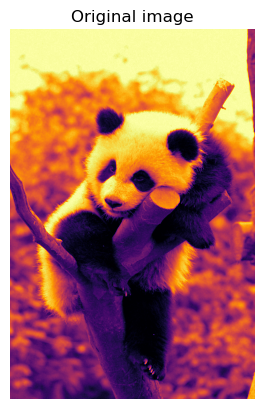

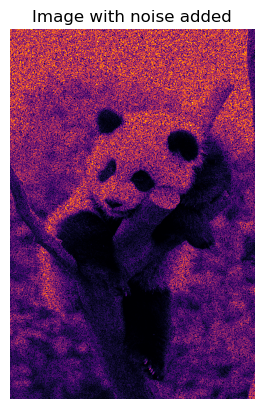

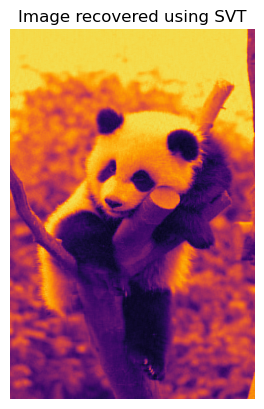

In [8]:
# read in the original image
original_image = cv2.imread('panda.jpg', 0)
# normalize the image
original_image = original_image / 255

# show the original image
plot.imshow(original_image, cmap='inferno')
plot.axis('off')
plot.title(f'Original image')
plot.show()

# select noise percentage to infuse the original with
noise_percentage=0.5
# add random noise to original image
mask = np.random.choice(a=[0,1], size=original_image.shape, p=[noise_percentage, 1-noise_percentage])
noise_image = np.multiply(original_image, mask)

# show image with noise percentage of noise_percentage value
plot.imshow(noise_image, cmap='inferno')
plot.axis('off')
plot.title(f'Image with noise added')
plot.show()

# show image processed with SVT
svt_image = svt(M=noise_image, eps=1e-4, delta=9e-1, k0=9.23e-1, l=1, steps=1000)
plot.imshow(svt_image, cmap='inferno')
plot.axis('off')
plot.title(f'Image recovered using SVT')
plot.show()